## Mathematical Simulation in Python, Billiard Dynamical Systems
### Summer Workshop in Mathematics, University of Brasilia
### Summer 2018, Session 2, Scott Cook

Goals:
1. Restructure code from session 1
2. Improve animations
3. Simulate the Lorentz Gas and observe the diffusion properties discussed in Carl Dettmann's survey https://github.com/drscook/unb_billiards/blob/master/references/Lorentz%20gas/dettmann_2014.pdf

## Goal 1 - Restructure code from session 1

The code we wrote in session 1 was not very clean.  We were trying to write code that reflects the order in which a mathematician might think about the components of the Sinai billiard.  I hoped this would be easier to learn from.  However, our code violated several coding best practices.  Let's try to clean it up.

This will require us to understand more about Python data structures:

https://github.com/jakevdp/WhirlwindTourOfPython/blob/master/06-Built-in-Data-Structures.ipynb

Specifically focus on lists and dictionaries.  Lists are ordered and indexed using numbers.  May contain entries with different types, including other lists, objects, arrays, functions, etc.  Follow link for list examples.

In [1]:
L = [1, 'Hello World', sum, list(range(2,9))]
print(L)
print(L[2](L[3]))  # applies the function in entry 2 to the list in entry 3
print(L[:2])   # gets the entries [0,2)
print(L[-1])  # gets the last entry
print(L[-2::-2])  # starts at the second-to-last entry and walks backward in steps of 2 until it reach the front

[1, 'Hello World', <built-in function sum>, [2, 3, 4, 5, 6, 7, 8]]
35
[1, 'Hello World']
[2, 3, 4, 5, 6, 7, 8]
[<built-in function sum>, 1]


Dictionaries are unordered and indexed using keys.  Advantage: you don't need to remember where something is stored because you reference it by "name".

In [2]:
d = {'son':'Kai', 'wife':'Megan', 'dog':'Caymin', 'age':37}
print(d)
print(d['age'])
d.update({'son':'Quinten', 'univ':'Tarleton State'})
print(d)  # note son was overwritten while univ was added

{'son': 'Kai', 'wife': 'Megan', 'dog': 'Caymin', 'age': 37}
37
{'son': 'Quinten', 'wife': 'Megan', 'dog': 'Caymin', 'age': 37, 'univ': 'Tarleton State'}


We will use this dictionary update trick to flexibly combined default parameters with user specified parameters.  Also, dictionaries are used with the python \*args, \**kwargs pattern for functions

https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/

Let us also move most of the code to a separate file so that we can more easily focus on the mathematically important parts.  See billiard_defs1.py

New pieces
- rnd = np.random.RandomState(seed) - a random number generator
- class Wall provides some default values as a Python dictionary.
- classes FlatWall and SphereWall have __init__ methods.  These are the preferred way to initialize values (rather than making an empty object and insering values later, like we did yesterday)
- First 6 lines of __init__ provide a flexible way to combine user specified values and defaults.  Duplicated Wall default are overwritten by FlatWall or SphereWall, which are again overwritten by the user specified parameters.
- **kwargs is a convenient way to allow any set of keyword arguments.
- Check conservation of energy

Done!! Steps = 100, Time = 875.922369


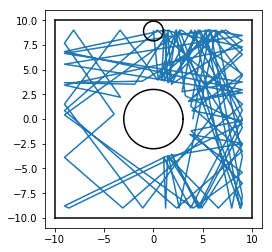

In [1]:
%matplotlib inline
seed = 10
%run -i billiard_defs_2a.py

dim = 2
x0 = 10
y0 = 10
R_particle = 1.0
R_scatter = 3.0

wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], gap_pad=R_particle)
        ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], gap_pad=R_particle)
        ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], gap_pad=R_particle)
        ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle)
       ]
for (i, w) in enumerate(wall):
    w.idx = i

part = Particles(max_steps=100, dim=dim, num=1, mass=[3], radius=[R_particle])
part.cell_size = [x0-part.radius[0], y0-part.radius[0]]
part.pos = np.array([[0,0.99*part.cell_size[1]]])
part.vel = np.array([[0.1,-1.0]])
part.KE_init = part.get_KE()
    
part.record_state()
for step in range(part.max_steps):
    next_state(wall, part)

clean_up(part)
draw_state()

## Goal 2 - Improve visualizations

Wouldn't it be great to interact with the graphics to see the system evolve step by step?  Let's do that!

In [2]:
import ipywidgets as widgets

def interactive_plot(num_frames=-1):
    max_frames = part.pos_hist.shape[0]-1
    if (num_frames == -1) or (num_frames > max_frames):
        num_frames = max_frames

    pos = part.pos_hist[:num_frames+1]
    dpos = np.diff(pos, axis=0)  # position change
    
    # Color particles (helpful for the future when we have many particles)
    cm = plt.cm.gist_rainbow
    idx = np.linspace(0, cm.N-1 , part.num).round().astype(int)
    clr = [cm(i) for i in idx]
    
    def update(i):
        s = max(i,1)
        fig, ax = plt.subplots(figsize=[8,8]);
        ax.set_aspect('equal')
        plt.title('s={} t={:.2f}'.format(s,part.t_hist[s]))
        for w in wall:
            ax.plot(*w.mesh.T, color='black')
        for p in range(part.num):
            ax.plot(pos[:s+1,p,0], pos[:s+1,p,1], color=clr[p])
            ax.plot(*(part.mesh[p] + pos[s,p]).T, color=clr[p])
        plt.show()

    l = widgets.Layout(width='150px')
    step_text = widgets.BoundedIntText(min=1, max=num_frames, value=1, layout=l)
    step_slider = widgets.IntSlider(min=1, max=num_frames, value=1, readout=False, continuous_update=False, layout=l)

    play_button = widgets.Play(min=1, max=num_frames, interval=250, layout=l)
    widgets.jslink((step_text, 'value'), (play_button, 'value'))

    img = widgets.interactive_output(update, {'i':step_text})
    display(widgets.HBox([widgets.VBox([step_text, step_slider, play_button]), img]))
    
interactive_plot()

A Jupyter Widget

## Goal 3 - Simulate the Lorentz Gas and observe the diffusion properties

As Dettmann describes, the Lorentz gas is a hexagonal lattice of circle scatterers.  Particle(s) can flow between them and diffuse outward.  We wish to simulate this system.  Steps:
1. Understand the geometry
2. Modify code to handle geometry
3. Modify code to allow multiple particles.


### 3.1 - Understand the geometry

From fig 1 in Dettmann's paper, we see that the plane can be tiled by rectangles with a scatterer in the center.  Let $g$ be the radius of the gap between neighboring scatterers; so the distance between centers of neighboring scatterers is 2\*(scatterer radius + gap).

There is a critical transition at gap$_{crit}$=$\left(\frac{2}{\sqrt{3}}-1\right)$ \* (scatterer radius + particle radius).
- If gap > gap$_{crit}$, the particle moving horizontally at y=(scatterer radius + gap) will never hit a scatterer.  We call this *infinite horizon*.
- If gap < gap$_{crit}$, a particle will always hit a scatterer in the future.  We call this *finite horizon*.
- If gap < particle_radius, a particle is trapped between 3 scatters.

So, we will express gap as a multiple of gap$_{crit}$.  Observe that $x_0=$gap + scatterer radius, $y_0=\sqrt{3} x_0$

We also must handle the unbounded domain.  Plan:
- FlatWalls are periodic (wrap around)
- We track which cell the particle is in 
- Each collision with a FlatWall adds +1 or -1 to the corresponding dimension of cell_offset
- FlatWalls "wrap around" like a torus - they are periodic
- FlatWalls have 0 wp_min_gap

### 3.2 - Modify code to handle geometry

Edit into billiard_def_2b.py

Done!! Steps = 100, Time = 2980.279060


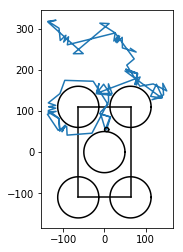

In [3]:
%matplotlib inline
seed = 10
# Note we use version 2b now
%run -i billiard_defs_2b.py

dim = 2
R_particle = 5.0
R_scatter = 50.0

R = R_particle + R_scatter
gap_crit = (2/np.sqrt(3) - 1) * R
gap = 1.0 * gap_crit

x0 = R + gap
y0 = np.sqrt(3) * x0

wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=1)
        ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=0)
        ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=3)
        ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=2)
        ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[-x0, -y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[x0, -y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[-x0, y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[x0, y0], radius=R_scatter, gap_pad=R_particle)
       ]
for (i, w) in enumerate(wall):
    w.idx = i

part = Particles(max_steps=100, cell_size=[x0, y0], dim=dim, num=1, mass=[3], radius=[R_particle])
part.cell_size = [x0, y0]
part.pos = np.array([[0,0.99*part.cell_size[1]]])
part.vel = np.array([[0.1,-1.0]])
part.KE_init = part.get_KE().sum()
    
for step in range(part.max_steps):
    next_state(wall, part)

next_state(wall, part)
clean_up(part)
draw_state()

Oops, we need to adjust our plots to draw more cells.

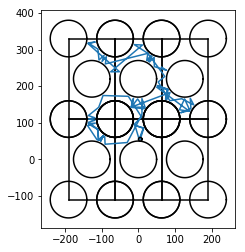

In [6]:
def draw_background(cell):
    ax = plt.gca()
    cell_range = [2 * s * np.arange(np.min(c), np.max(c)+1) for (s,c) in zip(part.cell_size, cell.T)]
    translates = it.product(*cell_range)
    if part.dim == 2:
        for trans in translates:
            for w in wall:
                ax.plot(*(w.mesh + trans).T, color='black')

def draw_state(steps=-1):
    pos = part.pos_hist[:steps]
    cell = part.cell_offset_hist[:steps]
    fig, ax = plt.subplots()
    draw_background(cell)
    for p in range(part.num):
        ax.plot(pos[:,p,0], pos[:,p,1])
        ax.plot(*(part.mesh[p]+pos[p,-1]).T, 'black')
    ax.set_aspect('equal')
    plt.show()
          
draw_state()

And the interactive version

In [7]:
import ipywidgets as widgets

def interactive_plot(num_frames=-1):
    max_frames = part.pos_hist.shape[0]-1
    if (num_frames == -1) or (num_frames > max_frames):
        num_frames = max_frames

    pos = part.pos_hist[:num_frames+1]
    dpos = np.diff(pos, axis=0)  # position change
    cell = part.cell_offset_hist[:num_frames+1]
    
    # Color particles (helpful for the future when we have many particles)
    cm = plt.cm.gist_rainbow
    idx = np.linspace(0, cm.N-1 , part.num).round().astype(int)
    clr = [cm(i) for i in idx]
    
    def update(i):
        s = max(i,1)
        fig, ax = plt.subplots(figsize=[8,8]);
        ax.set_aspect('equal')
        plt.title('s={} t={:.2f}'.format(s,part.t_hist[s]))
        draw_background(cell[:s+1])
        for p in range(part.num):
            ax.plot(pos[:s+1,p,0], pos[:s+1,p,1], color=clr[p])
            ax.plot(*(part.mesh[p] + pos[s,p]).T, color=clr[p])
        plt.show()

    l = widgets.Layout(width='150px')
    step_text = widgets.BoundedIntText(min=1, max=num_frames, value=1, layout=l)
    step_slider = widgets.IntSlider(min=1, max=num_frames, value=1, readout=False, continuous_update=False, layout=l)

    play_button = widgets.Play(min=1, max=num_frames, interval=250, layout=l)
    widgets.jslink((step_text, 'value'), (play_button, 'value'))

    img = widgets.interactive_output(update, {'i':step_text})
    display(widgets.HBox([widgets.VBox([step_text, step_slider, play_button]), img]))
    
interactive_plot()

A Jupyter Widget

### 3.3 Modify code to allow multiple particles.

Now, we extend the code to handle multiple particles.  In fact, we have been writing code that will make this easy.  Did you note that part.pos had shape (1,2)?  Why not just (2)?  The first entry will index each particle.

Simplifications we will change later
- Particles do not interact with each, only with walls.  Hence particles can pass through each other.
- Must initialize position explicitly.  Later, we will implement random initialization.
- We have the option to initialize velocity explicitly or randomly.

In [29]:
%%time
%matplotlib inline
seed = 10
# Note we use version 2c now
%run -i billiard_defs_2c.py

dim = 2
R_particle = 1.0
R_scatter = 10.0

R = R_particle + R_scatter
gap_crit = (2/np.sqrt(3) - 1) * R
gap = 0.7 * gap_crit

x0 = R + gap
y0 = np.sqrt(3) * x0

wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=1)
        ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], wp_collision_law='wp_wrap', wrap_dim=0, wrap_wall=0)
        ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=3)
        ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], wp_collision_law='wp_wrap', wrap_dim=1, wrap_wall=2)
        ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[-x0, -y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[x0, -y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[-x0, y0], radius=R_scatter, gap_pad=R_particle)
        ,SphereWall(dim=dim, base_point=[x0, y0], radius=R_scatter, gap_pad=R_particle)
       ]
for (i, w) in enumerate(wall):
    w.idx = i

num = 500
part = Particles(max_steps=10000, cell_size=[x0, y0], dim=dim, num=num
                 , mass= np.full(num, 3)
                 , radius=np.full(num, R_particle)
                )
part.cell_size = [x0, y0]
part.pos = np.array([[0, 0.8*part.cell_size[1]] for p in range(num)])

theta = rnd.uniform(0, 2*np.pi, num)
speed = 1.0
part.vel = speed * np.asarray([np.cos(theta), np.sin(theta)]).T

part.KE_init = part.get_KE().sum()
    
for step in range(part.max_steps):
    next_state(wall, part)

next_state(wall, part)
clean_up(part)

Done!! Steps = 10000, Time = 101.626063
Wall time: 9.29 s


In [ ]:
draw_state()

In [2]:
interactive_plot()

A Jupyter Widget

Now, let us observe the diffusion properties Dettmann describes in section 2.2. https://github.com/drscook/unb_billiards/blob/master/references/Lorentz%20gas/dettmann_2014.pdf

(10001, 500, 2)


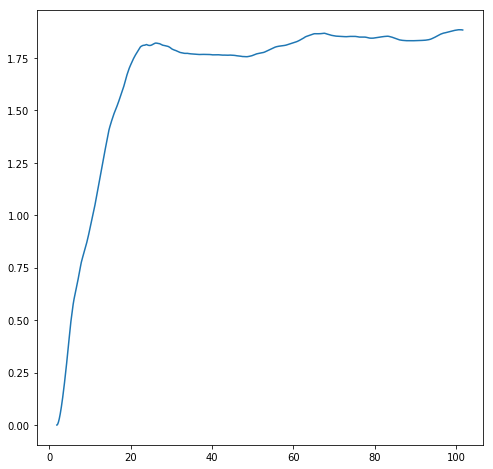

In [30]:
# Diffusion constant

displace = part.pos_hist - part.pos_hist[0]
print(displace.shape)
# shape is (dim, num_parts, steps)
msd = (displace**2).sum(axis=-1).mean(axis=-1)
D = msd / (2 * part.dim * part.t_hist)

fig, ax = plt.subplots(figsize=[8,8]);
ax.plot(part.t_hist,D) 
plt.show()


(2, 500, 10001)
(2, 2, 500, 10001)
(2, 2, 10001)


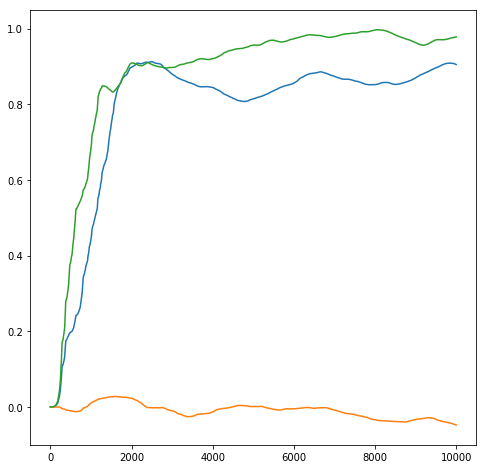

In [31]:
# Diffusion matrix D_ij

displace = (part.pos_hist - part.pos_hist[0]).T
print(displace.shape)
# shape is (dim, num_parts, steps)
delta = (displace[np.newaxis] * displace[:,np.newaxis])
print(delta.shape)
# shape is (dim, dim, num_parts, steps)
D = delta.mean(axis=2) / (2 * part.dim * part.t_hist)
print(D.shape)
# shape is (dim, dim, steps)

fig, ax = plt.subplots(figsize=[8,8]);
for d in range(part.dim):
    for e in range(d+1):
        ax.plot(D[d,e]) 
plt.show()
